In [1]:
import matplotlib.pyplot as plt
import geopandas
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#epsg = 'EPSG:3857'
epsg = "EPSG:4674" #sirgas 2000
#epsg = 'EPSG:3395' #world mercator

In [4]:
import cartopy.crs as ccrs
import numpy as np

def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [5]:
municipios = geopandas.read_file('municipios/Municipios_IBGE.shp')

In [6]:
#municipios.head()

In [7]:
brasil = geopandas.read_file('Brasil/UFEBRASIL.shp')
brasil = brasil.to_crs({'init': epsg})

In [8]:
rs = brasil[brasil['NM_ESTADO'] == 'RIO GRANDE DO SUL']

In [9]:
#rs

In [10]:
municipios = municipios.to_crs({'init': epsg})

In [11]:
lista_municipio = ['Caxias do Sul', 'Santa Maria', 'Porto Alegre', 'Pelotas']
def plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05):
    x = []
    y = []
    for index, row in municipios.iterrows():
        for m in lista_municipio:
            if row['NOME'] == m.upper():
                y.append(row['LATITUDESE'])
                x.append(row['LONGITUDES'])
    ax.scatter(x=x, y=y, marker='x', c=c)
    for i, txt in enumerate(lista_municipio[::-1]):
        ax.annotate(txt, (x[i]+delta, y[i]+delta), c=c)

In [12]:
muni_sup_veget = ['Rosario do Sul', 'Alegrete', 'Dom Pedrito', 'Encruzilhada do Sul', 'Santana do Livramento', 'Uruguaiana', 'Sao Gabriel', 'Bage', 'Piratini', 'Sao Borja', 'Itaqui', 'Jaguarao', 'Sao Francisco de Assis', 'Cachoeira do Sul', 'Santiago', 'Cacequi', 'Santa Maria', 'Macambara', 'Tupancireta']
muni_sup_veget_df = geopandas.GeoDataFrame()
muni_sup_veget_df.crs = epsg

for index, row in municipios.iterrows():
    for m in muni_sup_veget:
        if row['NOME'] == m.upper():
            print(row['NOME'])
            muni_sup_veget_df = muni_sup_veget_df.append(row)
            
#muni_sup_veget_df = muni_sup_veget_df.to_crs({'init': epsg})

ITAQUI
JAGUARAO
MACAMBARA
PIRATINI
SANTA MARIA
SANTANA DO LIVRAMENTO
SANTIAGO
SAO BORJA
SAO FRANCISCO DE ASSIS
SAO GABRIEL
TUPANCIRETA
URUGUAIANA
ROSARIO DO SUL
ALEGRETE
BAGE
CACEQUI
CACHOEIRA DO SUL
DOM PEDRITO
ENCRUZILHADA DO SUL


In [13]:
ucs = geopandas.read_file("ucs/ucstodas.shp")
ucs.crs = epsg
ucs = ucs.to_crs({'init': epsg})

In [14]:
#ucs.head()

In [15]:
ti = geopandas.read_file("ti_sirgas/ti_sirgasPolygon.shp")
ti = ti.to_crs({'init': epsg})
ti = ti[ti['uf_sigla'] == 'RS']

In [16]:
#ti.head()

In [17]:
fl = geopandas.read_file("florestas/florestaspublicas.shp")
fl.crs=epsg
fl = fl.to_crs({'init': epsg})

In [18]:
#fl.head()

In [19]:
#removendo nao RS
areas_amb = [ucs, fl]

for a in areas_amb:
    for idx, row in a.iterrows():
        p = row['geometry'].centroid
        if rs.iloc[0]['geometry'].contains(p):
            pass
        else:
            a.drop(idx, inplace=True)

In [20]:
areas_amb_concat = geopandas.pd.concat([ucs, fl, ti])

In [23]:
#1° = 111 km
buffer = 3/111
buffer10 = 10/111

In [24]:
b1 = ucs['geometry'].buffer(buffer, resolution=16)
b1 = geopandas.GeoDataFrame(geometry=b1)

b2 = fl['geometry'].buffer(buffer, resolution=16)
b2 = geopandas.GeoDataFrame(geometry=b2)

b3 = ti['geometry'].buffer(buffer, resolution=16)
b3=geopandas.GeoDataFrame(geometry=b3)

o1 = geopandas.overlay(b1, b2, how='union')
o2 = geopandas.overlay(o1, b3, how='union')

i1 = geopandas.overlay(b1, b2, how='intersection')
i2 = geopandas.overlay(o1, b3, how='intersection') 

overlay = geopandas.overlay(rs, o2, how='intersection')

In [25]:
sigmine = geopandas.read_file("RS/RS.shp")
sigmine = sigmine.to_crs({'init': epsg})
sigmine['ANM'] = 'ANM'

In [26]:
#sigmine.head()

In [27]:
filtro_req1 = sigmine['FASE'] != 'REQUERIMENTO DE PESQUISA'
filtro_req2 = sigmine['FASE'] != 'REQUERIMENTO DE LICENCIAMENTO'
filtro_req3 = sigmine['FASE'] != 'REQUERIMENTO DE LAVRA GARIMPEIRA'
filtro_req4 = sigmine['FASE'] != 'REQUERIMENTO DE REGISTRO DE EXTRAÇÃO'

sigmine = sigmine[filtro_req1 & filtro_req2 & filtro_req3 & filtro_req4]

In [28]:
#contagem geral de processos
municipios['contagem'] = 0
for idx, row in municipios.iterrows():
    nome = row['NOME']
    count = 0
    for idx1, row1 in sigmine.iterrows():
        if row['geometry'].contains(row1['geometry'].centroid):
            count = count + 1
            sigmine.drop(idx1, inplace=True)
    municipios.loc[idx, 'contagem'] = count

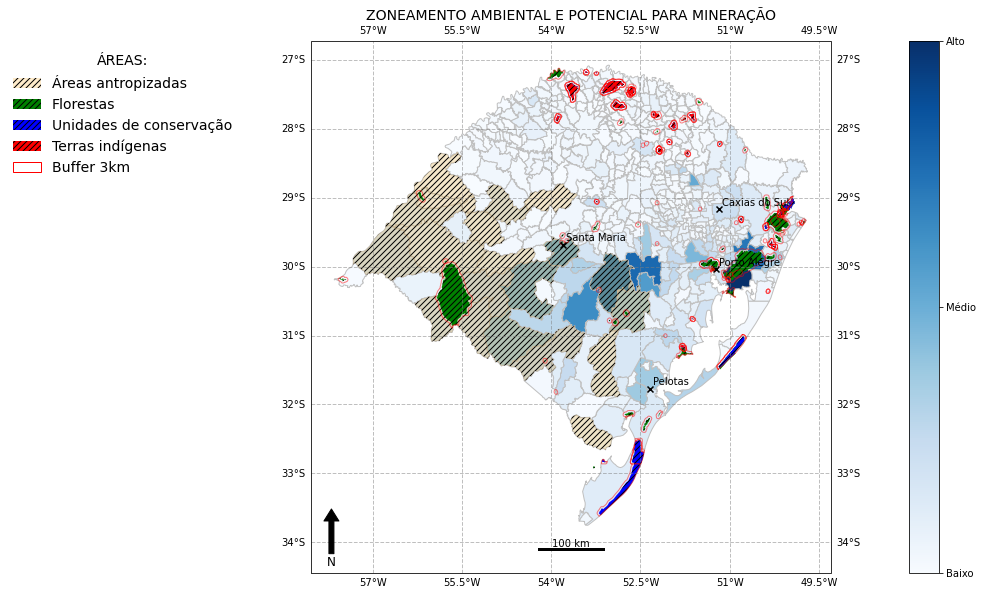

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': ccrs.PlateCarree()})

municipios.plot(ax=ax, column='contagem', legend=False, cmap='Blues', edgecolor='silver')

divider = make_axes_locatable(ax)
ax_cb = divider.new_horizontal(size="5%", pad=0.5, axes_class=plt.Axes)
vmax = municipios['contagem'].values.max()
mappable = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
fig.add_axes(ax_cb)
cbar = fig.colorbar(mappable, cax=ax_cb, ticks=[0, 50, 100])
cbar.ax.set_yticklabels(['Baixo', 'Médio', 'Alto'])



areas_amb = [muni_sup_veget_df, ucs, fl, ti,]
label = ['Áreas antropizadas','Florestas', 'Unidades de conservação', 'Terras indígenas', ]
colors = ['orange', 'green', 'blue', 'red', ]
alpha=[0.2,1,1,1,]

hand = []
for i, a in enumerate(areas_amb):
    a.plot(ax=ax, color = colors[i], hatch='////', alpha=alpha[i])

    h = mpatches.Patch(facecolor=colors[i],alpha=alpha[i],hatch='////',label=label[i])
    hand.append(h)
    
h = mpatches.Patch(facecolor='white',alpha=1, edgecolor='red', label='Buffer 3km')
hand.append(h)
    
lgd1 = plt.legend(handles = hand, bbox_to_anchor=(-22, 1), edgecolor = 'white', fontsize='14', title='ÁREAS:', title_fontsize='14', loc='upper right')
           
overlay.plot(ax=ax, facecolor=(0,0,0,0), edgecolor=(1,0,0,0.5))

    
scale_bar(ax, 100, location=(0.5,0.01))

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

x, y, arrow_length = 0.04, 0.12, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
arrowprops=dict(facecolor='black', width=5, headwidth=15),
ha='center', va='center', fontsize=12,
xycoords=ax.transAxes)

plot_municipios(municipios, lista_municipio, ax, c='black', delta=0.05)

ax.set_title('ZONEAMENTO AMBIENTAL E POTENCIAL PARA MINERAÇÃO', loc='center', fontsize='14')

plt.savefig("imagens/ambiental.png", bbox_inches='tight', facecolor='white', dpi = 300, bbox_extra_artists=([ax, lgd1]))

In [40]:
a_rs = rs.area
a_buffers = overlay.area
inter = i2.area

In [41]:
p = 100 - (np.sum(a_buffers.values)*100/np.sum(a_rs.values)) - (np.sum(inter.values))

In [42]:
round(p, 2)

92.68